In [48]:
from os import chmod

import numpy as np
import pandas as pd
from scipy.stats import truncnorm, norm
from six import print_


# Conditional skills
def conditional_skills(mu_s1, mu_s2, sigma_s1, sigma_s2, t, outcome_var):
    mean_s = np.array([mu_s1, mu_s2])
    cov_s = np.array([[sigma_s1, 0],
                      [0, sigma_s2]])  # Covariance matrix with S_12 and S_21
    outcome_mean = mu_s1 - mu_s2
    outcome_var = sigma_s1 + sigma_s2 + outcome_var # Outcome variance

    # Conditional mean update
    mean_cond = mean_s + (t - outcome_mean) / outcome_var * np.array([sigma_s1, -sigma_s2])

    # Conditional covariance update
    cov_cond = cov_s - np.outer([sigma_s1, -sigma_s2], [sigma_s1, -sigma_s2]) / outcome_var
  
    return mean_cond, cov_cond


# Conditional outcome (truncated Gaussian)
def conditional_outcome(mu_s1, mu_s2, result, outcome_var): #changed so that it only depends on mu_s1 and mu_s2
    mean_diff = mu_s1 - mu_s2
    std_diff = outcome_var

    # Set truncation limits based on match outcome
    if result == 1:
        a, b = 0, np.inf  # Truncate for team 1 winning
    else:
        a, b = -np.inf, 0  # Truncate for team 2 winning

    # Create truncated Gaussian distribution
    trunc_gauss_dist = truncnorm(a=(a - mean_diff) / std_diff, b=(b - mean_diff) / std_diff, loc=mean_diff, scale=std_diff)
    
    return a,b



# Marginal probability that team 1 wins
def marginal_p_y1(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t):
    mu_diff = mu_s1 - mu_s2
    sigma_diff = np.sqrt(sigma_s1 + sigma_s2 + sigma_t)
    p_y1 = 1 - norm.cdf(0, loc=mu_diff, scale=sigma_diff)
    return p_y1

#print("marginal_y =", marginal_p_y1(1, -1, 1, 4,5)) #Probability p(t > 0), e.g player 1 wins. Where t is the Gaussian random variable obtained by marginalizing out s1 and s2 from p(t, s1, s2).


#Gibbs sampler

def gibbs_sampler(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    y_samples = np.zeros(n_iter)
    s1, s2 = mu_s1, mu_s2
    
    for i in range(n_iter):
        y = 1 
        a, b = conditional_outcome(mu_s1, mu_s2, y, sigma_t)
        t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t)
        mean_cond, cov_cond = conditional_skills(mu_s1, mu_s2,sigma_s1, sigma_s2, t, sigma_t)
        s1, s2 = np.random.multivariate_normal(mean_cond, cov_cond)
        s1_samples[i] = s1
        s2_samples[i] = s2
        t_samples[i] = t
        y_samples[i] = y

    return s1_samples, s2_samples, t_samples

n_iter = 500 
mu_s1 = 25 # Initial mean for player 1
mu_s2 = 25 # Initial mean for player 2
sigma_s1 = 8.33 # Variance for player 1
sigma_s2 = 8.33 # Variance for player 2
sigma_t = 25/6 # Outcome variance

s1_samples, s2_samples, t_samples = gibbs_sampler(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter)

# Step 1: Calculate the means
mean_s1 = np.mean(s1_samples)
mean_s2 = np.mean(s2_samples)
mean_t = np.mean(t_samples)

# Step 2: Calculate the variances
var_s1 = np.var(s1_samples, ddof=1)
var_s2 = np.var(s2_samples, ddof=1)
var_t = np.var(t_samples, ddof=1)

    
        
            

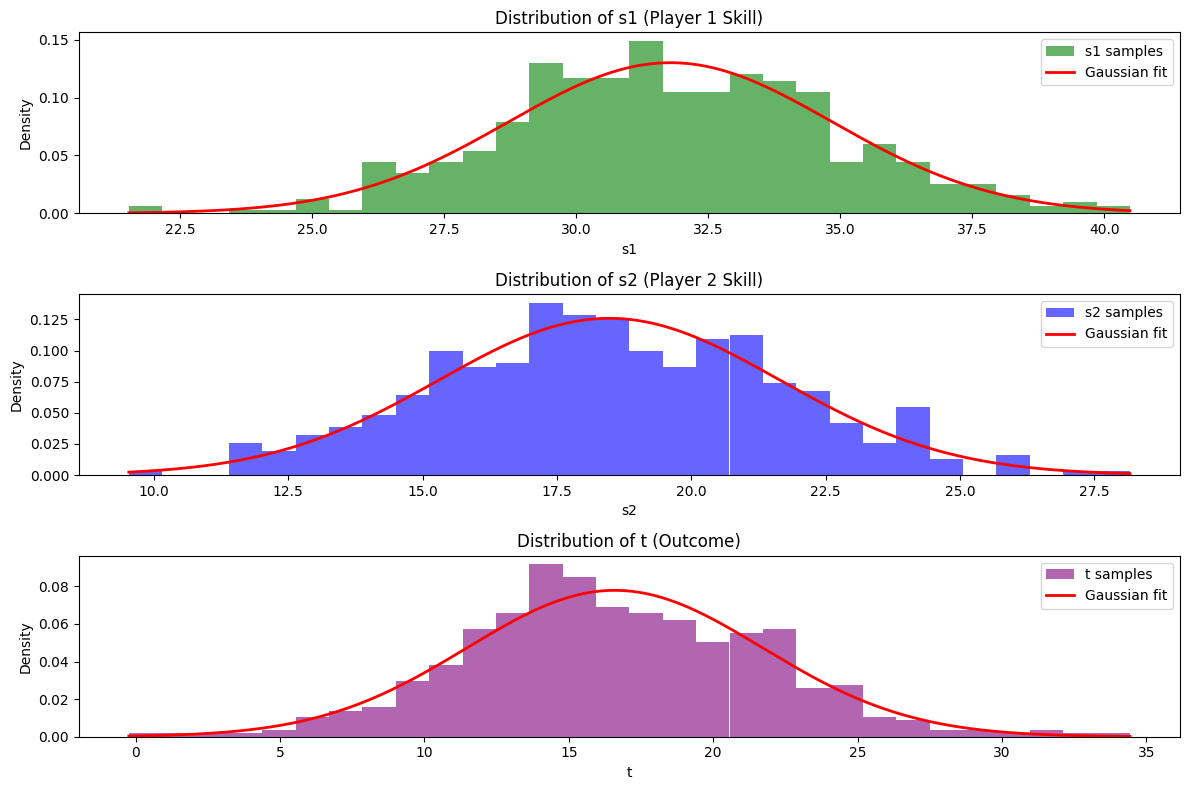

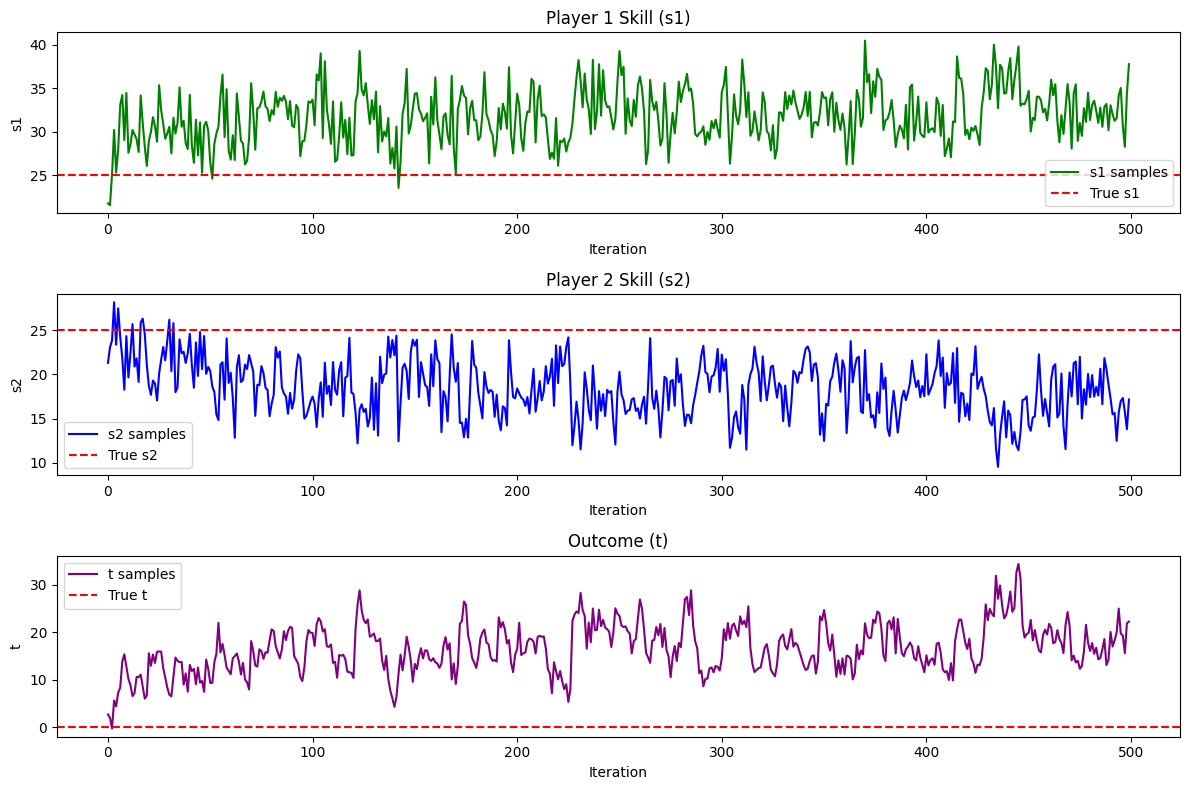

In [49]:
# Plot the samples
import matplotlib.pyplot as plt


# Step 3: Plot the histograms with fitted Gaussian curves
x_s1 = np.linspace(min(s1_samples), max(s1_samples), 1000)
x_s2 = np.linspace(min(s2_samples), max(s2_samples), 1000)
x_t = np.linspace(min(t_samples), max(t_samples), 1000)

# Plot s1 samples
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.hist(s1_samples, bins=30, density=True, alpha=0.6, color='g', label="s1 samples")
plt.plot(x_s1, norm.pdf(x_s1, mean_s1, np.sqrt(var_s1)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of s1 (Player 1 Skill)')
plt.xlabel('s1')
plt.ylabel('Density')
plt.legend()

# Plot s2 samples
plt.subplot(3, 1, 2)
plt.hist(s2_samples, bins=30, density=True, alpha=0.6, color='b', label="s2 samples")
plt.plot(x_s2, norm.pdf(x_s2, mean_s2, np.sqrt(var_s2)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of s2 (Player 2 Skill)')
plt.xlabel('s2')
plt.ylabel('Density')
plt.legend()

# Plot t samples
plt.subplot(3, 1, 3)
plt.hist(t_samples, bins=30, density=True, alpha=0.6, color='purple', label="t samples")
plt.plot(x_t, norm.pdf(x_t, mean_t, np.sqrt(var_t)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of t (Outcome)')
plt.xlabel('t')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(s1_samples, color='g', label="s1 samples")
plt.axhline(y=mu_s1, color='r', linestyle='--', label="True s1")
plt.title('Player 1 Skill (s1)')
plt.xlabel('Iteration')
plt.ylabel('s1')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(s2_samples, color='b', label="s2 samples")
plt.axhline(y=mu_s2, color='r', linestyle='--', label="True s2")
plt.title('Player 2 Skill (s2)')
plt.xlabel('Iteration')
plt.ylabel('s2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_samples, color='purple', label="t samples")
plt.axhline(y=mu_s1 - mu_s2, color='r', linestyle='--', label="True t")
plt.title('Outcome (t)')
plt.xlabel('Iteration')
plt.ylabel('t')
plt.legend()

plt.tight_layout()

plt.show()